In [11]:
import sys
import os
import csv
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [12]:
NUM_REPETITIONS = 30
ARRAY_SIZES = [str(i) for i in range(1000000, 10000001, 1000000)] 
EXECUTABLE_PATH = "../src/parallelQuicksort"

In [13]:
def save_results_to_csv(results_data, filename):
    if not results_data:
        print(f"No data collected to save to {filename}.")
        return
    fieldnames = ['size', 'run', 'sequential_time', 'parallel_time', 'builtin_time']
    try:
        with open(filename, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(results_data)
        return True
    except Exception as e:
        print(f"\n ERROR - Failed to save results to CSV: {e}")
        return False

## Experiment run

In [14]:
import subprocess

def execute_quicksort(array_size):
    command = [EXECUTABLE_PATH, array_size]

    try:
        result = subprocess.run(
            command,
            check=True,
            capture_output=True,
            text=True
        )
        if result.returncode == 0:
            print(f"The program ran successfully.")
        return result
    except Exception as e:
        print(f"\nAn error occurred: {e}")

def get_times(result):
    lines = result.stdout.splitlines()
    sequential_time = float(lines[0].split()[3])
    parallel_time   = float(lines[1].split()[3])
    builtin_time    = float(lines[2].split()[3])
    return [sequential_time, parallel_time, builtin_time]


In [15]:
def conduct_experiments(array_sizes, repetitions):
    all_results = []
    output_filename = "quicksort_results.csv"

    print(f"Starting Experiment: {repetitions} repetitions per array size.")
    print(f"Results will be saved to: {output_filename}")

    for size in array_sizes:
        for i in range(1, NUM_REPETITIONS+1):
            result = execute_quicksort(size)
            if result and result.returncode == 0:
                try:
                    sequential_time, parallel_time, builtin_time = get_times(result)
                    print(f" Success. Times (s/p/b): {sequential_time:.4f} / {parallel_time:.4f} / {builtin_time:.4f}")

                    all_results.append({
                        'size': size,
                        'run': i,
                        'sequential_time': sequential_time,
                        'parallel_time': parallel_time,
                        'builtin_time': builtin_time,
                    })
                except Exception as e:
                    print(f" ERROR: {e}")
            elif result is None:
                print(" FAILED ")
                save_results_to_csv(all_results, "quicksort_results_partial.csv")
                sys.exit(1)
            else:
                print(f" FAILED - Program returned non-zero code: {result.returncode}")

    if save_results_to_csv(all_results, output_filename):
        return output_filename
    else:
        return None

## Plotting & CI computation

In [16]:
def plot_results(filename):
    try:
        df = pd.read_csv(filename)
        df['size'] = pd.to_numeric(df['size'])

        grouped = df.groupby('size')
        avg_times = grouped[['sequential_time', 'parallel_time', 'builtin_time']].mean()
        
        # Calculate 90% confidence intervals
        def calculate_ci(data):
            n = len(data)
            if n < 2:
                return 0
            sem = data.sem()  # Standard error of the mean
            return 1.645 * sem  # 90% ci
        
        seq_ci = grouped['sequential_time'].apply(calculate_ci)
        par_ci = grouped['parallel_time'].apply(calculate_ci)
        builtin_ci = grouped['builtin_time'].apply(calculate_ci)
        
        NUM_REPETITIONS = grouped.size().iloc[0]

        plt.figure(figsize=(6, 4))

        array_sizes = [int(x) for x in avg_times.index]

        # Plot with error bars for confidence intervals
        plt.errorbar(array_sizes, avg_times['sequential_time'], 
                    yerr=seq_ci.values, label='Sequential Quicksort',
                    marker='o', capsize=5, capthick=2, linestyle='-', linewidth=2)
        
        plt.errorbar(array_sizes, avg_times['parallel_time'], 
                    yerr=par_ci.values, label='Parallel Quicksort',
                    marker='s', capsize=5, capthick=2, linestyle='-', linewidth=2)
        
        plt.errorbar(array_sizes, avg_times['builtin_time'], 
                    yerr=builtin_ci.values, label='Built-in (Reference) Sort',
                    marker='^', capsize=5, capthick=2, linestyle='-', linewidth=2)

        # Formatting
        title_string = f'Quicksort Performance: Time vs. Array Size\n(Average of {NUM_REPETITIONS} runs with 90% Confidence Intervals)'
        plt.title(title_string, fontsize=14, pad=20)
        plt.xlabel('Array Size', fontsize=12)
        plt.ylabel('Average Execution Time (s)', fontsize=12)

        plt.grid(True, which="both", ls="--", alpha=0.6)
        plt.legend(fontsize=11)
        
        # Use log scale if data spans large ranges
        if max(array_sizes) / min(array_sizes) > 100:
            plt.xscale('log')
        max_time = max(avg_times['sequential_time'].max(), avg_times['parallel_time'].max(), avg_times['builtin_time'].max())
        min_time = min(avg_times['sequential_time'].min(), avg_times['parallel_time'].min(), avg_times['builtin_time'].min())
        if max_time / min_time > 100:
            plt.yscale('log')

        # Save the plot
        plot_filename = filename.replace('.csv', '_with_CI.png')
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"[SUCCESS] Plot saved to {plot_filename}")
        
    except Exception as e:
        print(f"\nAn error occurred: {e}")
        import traceback
        traceback.print_exc()

Starting Experiment: 20 repetitions per array size.
Results will be saved to: quicksort_results.csv
The program ran successfully.
 Success. Times (s/p/b): 0.0154 / 0.4502 / 0.0122
The program ran successfully.
 Success. Times (s/p/b): 0.0126 / 0.4118 / 0.0124
The program ran successfully.
 Success. Times (s/p/b): 0.0124 / 0.3438 / 0.0121
The program ran successfully.
 Success. Times (s/p/b): 0.0122 / 0.3376 / 0.0159
The program ran successfully.
 Success. Times (s/p/b): 0.0154 / 0.2895 / 0.0121
The program ran successfully.
 Success. Times (s/p/b): 0.0125 / 0.4835 / 0.0175
The program ran successfully.
 Success. Times (s/p/b): 0.0129 / 0.3102 / 0.0122
The program ran successfully.
 Success. Times (s/p/b): 0.0122 / 0.3378 / 0.0121
The program ran successfully.
 Success. Times (s/p/b): 0.0121 / 0.3273 / 0.0117
The program ran successfully.
 Success. Times (s/p/b): 0.0121 / 0.3828 / 0.0193
The program ran successfully.
 Success. Times (s/p/b): 0.0140 / 0.3304 / 0.0123
The program ran succ

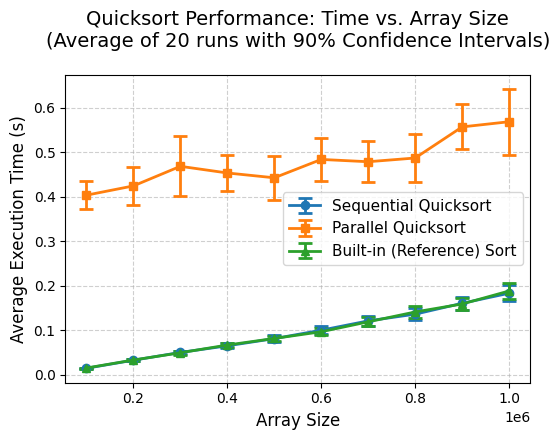

[SUCCESS] Plot saved to quicksort_results_with_CI.png


In [17]:
ARRAY_SIZES = [str(i) for i in range(100000, 1000001, 100000)] 
NUM_REPETITIONS = 20
final_csv_file = conduct_experiments(ARRAY_SIZES, NUM_REPETITIONS)

if final_csv_file:
    print(ARRAY_SIZES)
    print("Plotting...")
    plot_results(final_csv_file)

Starting Experiment: 20 repetitions per array size.
Results will be saved to: quicksort_results.csv
The program ran successfully.
 Success. Times (s/p/b): 0.2412 / 0.5439 / 0.1459
The program ran successfully.
 Success. Times (s/p/b): 0.1398 / 0.5137 / 0.2367
The program ran successfully.
 Success. Times (s/p/b): 0.2269 / 0.5202 / 0.1430
The program ran successfully.
 Success. Times (s/p/b): 0.1376 / 0.4416 / 0.2066
The program ran successfully.
 Success. Times (s/p/b): 0.2425 / 0.6630 / 0.2402
The program ran successfully.
 Success. Times (s/p/b): 0.2412 / 0.5598 / 0.1447
The program ran successfully.
 Success. Times (s/p/b): 0.1444 / 0.4955 / 0.2341
The program ran successfully.
 Success. Times (s/p/b): 0.2726 / 0.7435 / 0.2154
The program ran successfully.
 Success. Times (s/p/b): 0.2272 / 0.4742 / 0.1455
The program ran successfully.
 Success. Times (s/p/b): 0.1480 / 0.4749 / 0.2316
The program ran successfully.
 Success. Times (s/p/b): 0.2357 / 0.6064 / 0.1411
The program ran succ

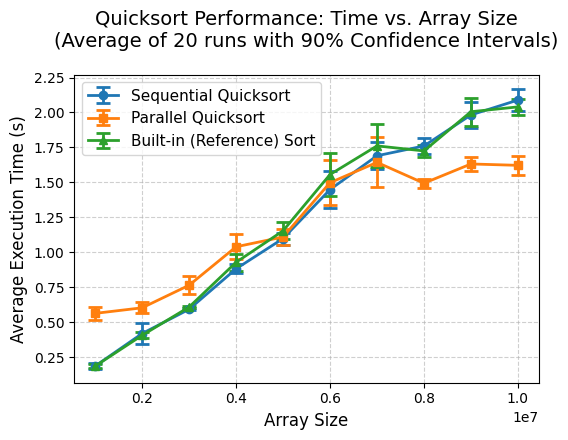

[SUCCESS] Plot saved to quicksort_results_with_CI.png


In [18]:
ARRAY_SIZES = [str(i) for i in range(1000000, 10000001, 1000000)] 
final_csv_file = conduct_experiments(ARRAY_SIZES, NUM_REPETITIONS)

if final_csv_file:
    print(ARRAY_SIZES)
    print("Plotting...")
    plot_results(final_csv_file)

## Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
# we suppose we have final_csv_file
df = pd.read_csv(final_csv_file)

sizes = df[['size']]
sequential_times = df['sequential_time']
parallel_times = df['parallel_time']
builtin_times = df['builtin_time']

In [21]:
X_seq = sizes
y_seq = sequential_times
model_seq = LinearRegression().fit(X_seq, y_seq)

X_par = sizes
y_par = parallel_times
model_par = LinearRegression().fit(X_par, y_par)

X_bi = sizes
y_bi = builtin_times
model_bi = LinearRegression().fit(X_bi, y_bi)

/home/masa/Documents/ENSIMAG/SMPE/SMPE-2025-2026-M2AI/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/masa/Documents/ENSIMAG/SMPE/SMPE-2025-2026-M2AI/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/masa/Documents/ENSIMAG/SMPE/SMPE-2025-2026-M2AI/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


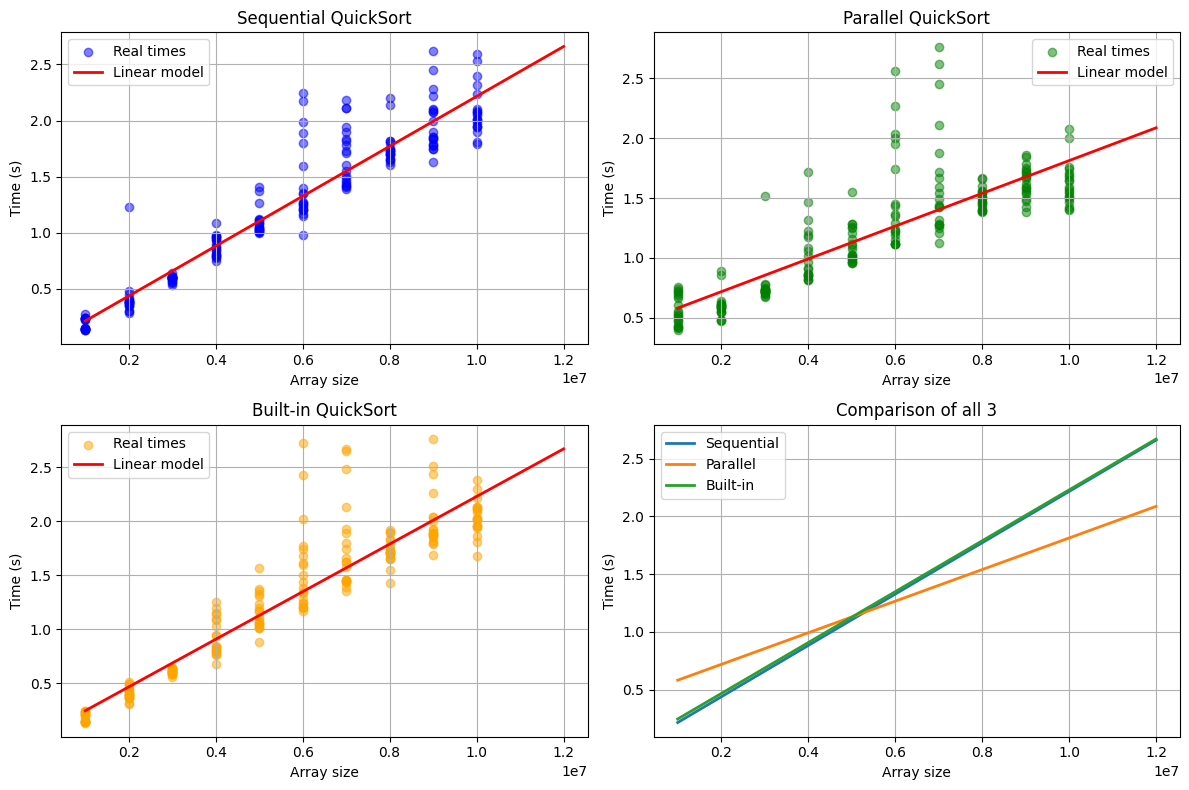

In [22]:
sample_sizes = np.linspace(df['size'].min(), df['size'].max() * 1.2, 100).reshape(-1, 1)

# Predict times for all three models
pred_seq = model_seq.predict(sample_sizes)
pred_par = model_par.predict(sample_sizes)
pred_bi = model_bi.predict(sample_sizes)

plt.figure(figsize=(12, 8))

# Sequential
plt.subplot(2, 2, 1)
plt.scatter(df['size'], df['sequential_time'], alpha=0.5, label='Real times', color='blue')
plt.plot(sample_sizes, pred_seq, label='Linear model', color='red', linewidth=2)
plt.xlabel('Array size')
plt.ylabel('Time (s)')
plt.title('Sequential QuickSort')
plt.legend()
plt.grid(True)

# Parallel
plt.subplot(2, 2, 2)
plt.scatter(df['size'], df['parallel_time'], alpha=0.5, label='Real times', color='green')
plt.plot(sample_sizes, pred_par, label='Linear model', color='red', linewidth=2)
plt.xlabel('Array size')
plt.ylabel('Time (s)')
plt.title('Parallel QuickSort')
plt.legend()
plt.grid(True)

# Built-in
plt.subplot(2, 2, 3)
plt.scatter(df['size'], df['builtin_time'], alpha=0.5, label='Real times', color='orange')
plt.plot(sample_sizes, pred_bi, label='Linear model', color='red', linewidth=2)
plt.xlabel('Array size')
plt.ylabel('Time (s)')
plt.title('Built-in QuickSort')
plt.legend()
plt.grid(True)

# All three for comparison
plt.subplot(2, 2, 4)
plt.plot(sample_sizes, pred_seq, label='Sequential', linewidth=2)
plt.plot(sample_sizes, pred_par, label='Parallel', linewidth=2)
plt.plot(sample_sizes, pred_bi, label='Built-in', linewidth=2)
plt.xlabel('Array size')
plt.ylabel('Time (s)')
plt.title('Comparison of all 3')
plt.legend()
plt.grid(True)

plt.tight_layout()

# SAVE THE PLOT HERE (before show())
plt.savefig('quicksort_performance_analysis.png', dpi=300, bbox_inches='tight')

plt.show()